# US Drinking Water Health-Based Quality Violations

The US Environmental Progection Agency EPA is publishing datasets about US water systems through its [envirofacts](https://www3.epa.gov/enviro/) platform. Information about safe drinking water is stored in SDWIS, the EPA's Safe Drinking Water Information System. The [SDWIS](https://www.epa.gov/enviro/sdwis-model) consists of several tables, that can be joined through unique IDs.   

The types of violations collected by the EPA are diverse, e.g also procedural violations, but I will concentrate on health-based violations, that are more interesting to me.  

In this analysis, I will explore the health-based violations of drinking water quality and try to answer the following questions:

1. How many health-based drinking water violations happen per year?
2. How many water system are affected by those violations?
3. How many people are concernded by those violations?

[... say why the datasets and my questions are relevant/important...]

In [253]:
# set up the environment:

import pandas as pd
import numpy as np
import requests # to read the data from the REST API of EPA Envirofacts
import csv # needed as data accessed through the REST API are .csv (other possibilities are .xml or .xls)

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt # to handle the dates in the dataset more easily

import seaborn as sns # I want to try seaborn for plotting. It looks to combine well with pandas.

## Health-Based Violations

One table - _VIOLATIONS_ - contains all the violations. According to the EPA, violations are detected by assessment of sample results or reviews (including on site visits). Examples of violations are Maximum Contaminant Level (MCL) violations, failure to replace lead service lines, treatment technique violations, procedural violations... I access the data through [Envirofacts RESTful API](https://www.epa.gov/enviro/web-services). I select only health-based violations.  

In [254]:
# read data: (! takes 3min)
CSV_URL = 'http://iaspub.epa.gov/enviro/efservice/VIOLATION/IS_HEALTH_BASED_IND/Y/ROWS/0:300000/CSV'
# notes on the API:
#     - VIOLATION = table
#     - IS_HEALTH_BASED_IND/Y ==> select only health-based violations
#     - ROWS/0:300000 ==> the default is to extract to first 10'000 rows. I want all rows, so i use a larger number

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    violations = list(cr)
    
# create a data frame with the data:
violations = pd.DataFrame(violations)
new_header = violations.iloc[0] # grab the first row for the header
new_header = new_header.str.split('.').str[1] # we remove the redundant table name (VIOLATION) in column names
violations = violations[1:] # take the data less the header row
violations.columns = new_header # set the header row as the df header
# we remove the last column of null, that is an artifact of the extraction:
violations = violations.dropna(axis = 1, how='all') # axis = 1 to specify that we talk about the columns

In [255]:
print(violations.shape)
violations.head()
# violations.IS_HEALTH_BASED_IND.value_counts() # a check.

(249535, 34)


,PWSID,VIOLATION_ID,FACILITY_ID,POPULATION_SERVED_COUNT,NPM_CANDIDATE,PWS_ACTIVITY_CODE,PWS_DEACTIVATION_DATE,PRIMARY_SOURCE_CODE,POP_CAT_5_CODE,PRIMACY_AGENCY_CODE,...,LATEST_ENFORCEMENT_ID,RTC_ENFORCEMENT_ID,RTC_DATE,PUBLIC_NOTIFICATION_TIER,ORIGINATOR_CODE,SAMPLE_RESULT_ID,CORRECTIVE_ACTION_ID,RULE_CODE,RULE_GROUP_CODE,RULE_FAMILY_CODE
1,VA2109825,2819424,,100,N,A,,GW,1,VA,...,194384,194383,23-NOV-15,2,S,,,110,100,110
2,VA1063220,2211509,,2300,N,A,,GW,2,VA,...,323521,323520,18-NOV-13,2,S,,,110,100,110
3,VA1063220,2211507,,2300,N,A,,GW,2,VA,...,323513,323512,01-FEB-10,2,S,,,110,100,110
4,VA1063220,2211508,,2300,N,A,,GW,2,VA,...,323516,323516,01-SEP-10,2,S,,,110,100,110
5,VA1063220,2211203,,2300,N,A,,GW,2,VA,...,323104,323104,01-OCT-03,2,S,,,350,300,350


In [256]:
# violations.describe()
violations.columns.values

array(['PWSID', 'VIOLATION_ID', 'FACILITY_ID', 'POPULATION_SERVED_COUNT',
       'NPM_CANDIDATE', 'PWS_ACTIVITY_CODE', 'PWS_DEACTIVATION_DATE',
       'PRIMARY_SOURCE_CODE', 'POP_CAT_5_CODE', 'PRIMACY_AGENCY_CODE',
       'EPA_REGION', 'PWS_TYPE_CODE', 'VIOLATION_CODE',
       'VIOLATION_CATEGORY_CODE', 'IS_HEALTH_BASED_IND',
       'CONTAMINANT_CODE', 'COMPLIANCE_STATUS_CODE', 'VIOL_MEASURE',
       'UNIT_OF_MEASURE', 'STATE_MCL', 'IS_MAJOR_VIOL_IND',
       'SEVERITY_IND_CNT', 'COMPL_PER_BEGIN_DATE', 'COMPL_PER_END_DATE',
       'LATEST_ENFORCEMENT_ID', 'RTC_ENFORCEMENT_ID', 'RTC_DATE',
       'PUBLIC_NOTIFICATION_TIER', 'ORIGINATOR_CODE', 'SAMPLE_RESULT_ID',
       'CORRECTIVE_ACTION_ID', 'RULE_CODE', 'RULE_GROUP_CODE',
       'RULE_FAMILY_CODE'], dtype=object)

In [257]:
# violations.dtypes # a check. (later we convert COMPL_PER_BEGIN_DATE to the datetime type)

In [258]:
# On the contrary to what was expected, the VIOLATION_ID is not a unique identifier:
# print(len(violations['PWSID']))
# print(len(set(violations['PWSID'])))
print("Number of rows in dataset: " + str(len(violations['VIOLATION_ID'])))
print("Number of distinct violations IDs: " + str(len(set(violations['VIOLATION_ID']))))
# print(len(violations['FACILITY_ID']))
# print(len(set(violations['FACILITY_ID'])))

# print(violations.set_index(list(violations)).index.is_unique) # but there are no repeated rows.
# print(violations.set_index(list(violations)[0:2]).index.is_unique) # combine system and violations to have uniques

# ==> the same violation can be present in several water system (PWSID). 

# # Thus, I create a unique identifier for the dataset:
# violations['my_distinct_violations_ID'] = violations['PWSID'] + "_" + violations['VIOLATION_ID']
# # It is not sure that I will use it in this analysis, but it might be useful in the future, 
# # if I pursue the analysis 


Number of rows in dataset: 249535
Number of distinct violations IDs: 145411


## How many Health-Based Drinking Water Violations Happen per Year?

The dataset of violations contains 249535 observations, but the VIOLATION_ID contains only 145411 unique values. After inspection, I found that the reason is that the same violation can be present in several water systems (PWSID). I will look at the number of unique violations, thus look at how theses 145411 violations are distributed over the years in the dataset.  

The dataset contains violations from year 1978 to 2018 (and a few in 2064, that I removed as they are probably an error). We observe that __the number of detected - and reported - violations increased greatly in recent years, particularly after 2008__. As from 2009, the number of violations observed per year varies between around 18'000 to 20'000.  

The dataset contains very few violations detected before 2007. __This is more likely to reflect the introduction of new regulations than a real increase in the number of violations__. However, as the population of the US also increased in parallel (or new industries, or an increase of the use of hydraulic fracking, see [EPA's Study](https://cfpub.epa.gov/ncea/hfstudy/recordisplay.cfm?deid=332990)), it could be worth digging more into this question to try to disentangle the effects.   

The drop in violations detection from 2016 to 2018 is probably due to the fact that not all analyses are finished or were entered in the system yet. Alternatively, it could also be due to the different priorities of the Trump administration regarding clean water (e.g. [suspension of the clean water rule](https://en.wikipedia.org/wiki/Clean_Water_Rule)). It is too early for me to conclude on that matter (witout contacting the EPA directly).    

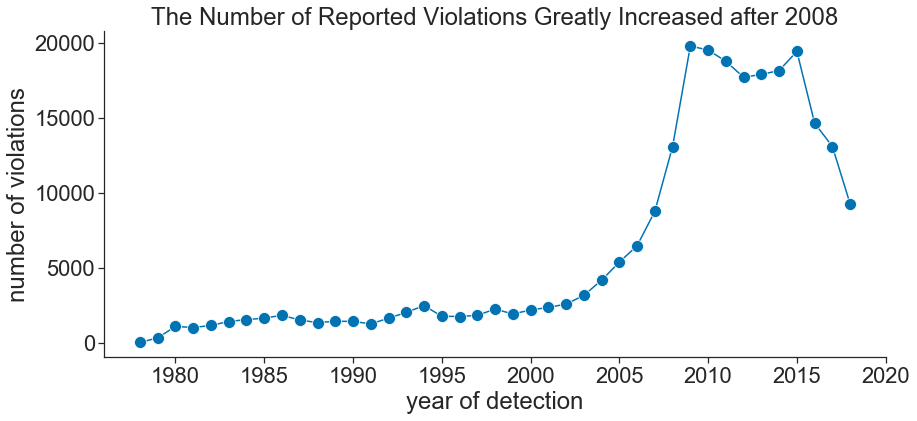

In [259]:
# COMPL_PER_BEGIN_DATE: represents the beginning of a period of time when 
# a public water system was in violation of a primary drinking water regulation.
# we convert the date to a datetime type, so it will be easier to work with:
violations['COMPL_PER_BEGIN_DATE'] =  pd.to_datetime(violations['COMPL_PER_BEGIN_DATE']) 
# add a column with the year only (start year of the violation):
violations['start_year'] = violations['COMPL_PER_BEGIN_DATE'].dt.year

# the data contains some violations with start_year in the future (we have some in 2064)
violations = violations.loc[violations['start_year'] <= 2018]

# we are now interested only in the violations and the year when they occur. 
# so I will create a dataset with violations only (i do this because VIOLATION_ID are not unique)
unique_violations = violations[['VIOLATION_ID', 'start_year']]

# and then we group by year to count the violations:
unique_violations_per_year = unique_violations.groupby(['start_year'], as_index=False).count()

sns.set(style="ticks", palette="colorblind", font_scale=2) # set the style of plot I want. 

plt.figure(figsize=(14, 6))
p = sns.lineplot(x="start_year", y="VIOLATION_ID",
             marker="o", markersize=12,
             data=unique_violations_per_year)
# p.add_legend(title="Meal")
p.set(xlabel='year of detection', ylabel='number of violations', 
      title = 'The Number of Reported Violations Greatly Increased after 2008')
#      xticks=range(1978,2019,5))
sns.despine()
plt.show()


## How many water system are affected by those violations?

We saw that around 20'000 yearly drinking water violations were observed in the recent years, but how are those violations distributed over the water systems? Are those violations widespread or restricted to a few "bad performing" water systems? I will try to quantify the distribution of these violations among the water systems.  



In [260]:
# for this, I need to read another table that stores all the water systems:

# read the data from the REST API of EPA Envirofacts, for the water system table. - takes 5min.
# CSV_URL = 'http://iaspub.epa.gov/enviro/efservice/WATER_SYSTEM/PWS_ACTIVITY_CODE/A/ROWS/0:150000/CSV'
CSV_URL = 'http://iaspub.epa.gov/enviro/efservice/WATER_SYSTEM/ROWS/0:500000/CSV'

# notes on the API:
#     - WATER_SYSTEM = table
#     - PWS_ACTIVITY_CODE/A ==> select only active water systems
#     - ROWS/0:150000 ==> the default is to extract to first 10'000 rows. I want all rows, so i use a larger number

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    WATER_SYSTEM = list(cr)

# create a data frame with the data:
WATER_SYSTEM = pd.DataFrame(WATER_SYSTEM)
new_header = WATER_SYSTEM.iloc[0] # grab the first row for the header
new_header = new_header.str.split('.').str[1] # we remove the redundant table name (WATER_SYSTEM) in column names
WATER_SYSTEM = WATER_SYSTEM[1:] # take the data less the header row
WATER_SYSTEM.columns = new_header # set the header row as the df header

# we remove the last column of null, that is an artifact of the extraction:
WATER_SYSTEM = WATER_SYSTEM.dropna(axis = 1, how='all') # axis = 1 to specify that we talk about the columns
# we note that 2 columns extracted are not in the EPA data dictionary: CITIES_SERVED, NPM_CANDIDATE ?


In [261]:
# np.shape(WATER_SYSTEM)
print("There are " + str(len(WATER_SYSTEM['PWSID'])) + " distinct water systems in the dataset.")
# print(len(set(WATER_SYSTEM['PWSID']))) PWSID is a unique ID


There are 327802 distinct water systems in the dataset.


Because the quantity of data about the violations varies over the years, I choose to focus on one single year. __I will continue the analysis with the last year were the data seems to be complete: 2016.__ I filter the water systems to take only those that were active in 2016. This leaves us with 153'584 water systems, in which 11'428 distinct health-based violations were observed.  

In [262]:
# we create a dataframe with the violations observed in 2016:
violations_2016 = violations[violations['start_year'] == 2016]
print(np.shape(violations_2016)) # note: rows are not unique, several repeated VIOLATION_ID
violations_2016.VIOLATION_ID.unique().shape[0] # number of distinct violations.

(14648, 35)


11428

In [263]:
# convert the deactivation date to datetime type, in oder to filter by date below:
WATER_SYSTEM['PWS_DEACTIVATION_DATE'] = pd.to_datetime(WATER_SYSTEM['PWS_DEACTIVATION_DATE'])

# we create a dataframe with all the water systems that are active (PWS_ACTIVITY_CODE == A),
# or that where deactivated between 2016 and now.
# (only the deactivated water systems get a deactivation date, the other don't.)
ws_2016 = WATER_SYSTEM[(WATER_SYSTEM['PWS_ACTIVITY_CODE'] == 'A') | 
                       (WATER_SYSTEM['PWS_DEACTIVATION_DATE'] > '2016-12-31')]
np.shape(ws_2016)

(121162, 47)

In [264]:
# before joining the two datasets, I decide that I will keep only some of the variables.
# this is not a necessity, but as I am only exploring and answering a few questions, 
# it is easier to 'see' the data:
ws_2016 = ws_2016[['PWSID', 'PWS_NAME', 'STATE_CODE', 'COUNTIES_SERVED', 'CITIES_SERVED']]
violations_2016 = violations_2016[['PWSID', 'VIOLATION_ID', 'POPULATION_SERVED_COUNT']]

# we join the two datasets. As we want to see the distribution of all the 2016 violations in the water systems, 
# we want to keep all the violations in the joined data, so we do a left join (not inner)
# (and thus, as we saw that one violation can concern several water systems, we keep all of those)
ws_with_violations_in_2016 = pd.merge(violations_2016, ws_2016, how='left', on=['PWSID'])


__In 2016, one (or more) health-based violation was reported in around 5% of the water systems.__

In [266]:
n_active_ws_in_2016 = ws_2016.PWSID.unique().shape[0]
n_ws_with_violation_in_2016 = ws_with_violations_in_2016.PWSID.unique().shape[0]
percentage = n_ws_with_violation_in_2016 / n_active_ws_in_2016 * 100

print('Out of the ' + 
      str(n_active_ws_in_2016) + 
      ' water systems active in 2016, in ' + 
      str(n_ws_with_violation_in_2016) +
      ' of them (' +
      str(round(percentage,1)) +
     '%), one or more health-based violation was reported.')

Out of the 121162 water systems active in 2016, in 6352 of them (5.2%), one or more health-based violation was reported.


In the histogram below, we see the distribution of the number of violations by water system, in 2016.

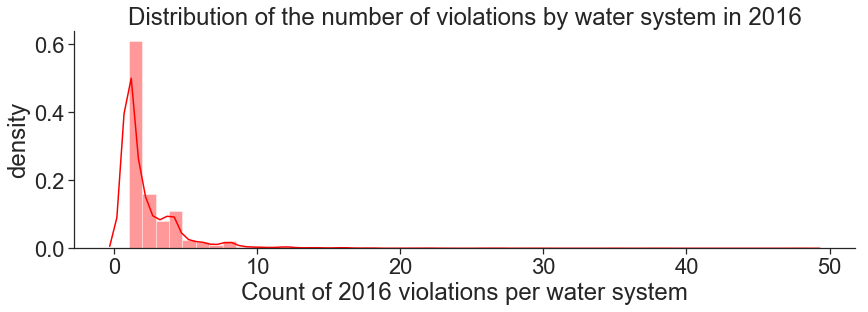

In [271]:
count_viol = ws_with_violations_in_2016[['PWSID', 'VIOLATION_ID']] # simplify by keeping only what we need
count_viol = count_viol.groupby('PWSID', as_index=False).count() # count the number of violations by water system
count_viol.sort_values(by = 'VIOLATION_ID', ascending = False, inplace = True)

plt.figure(figsize=(14, 4))

p = sns.distplot(count_viol.VIOLATION_ID, color='red')
p.set(xlabel='Count of 2016 violations per water system', ylabel='density', 
      title = 'Distribution of the number of violations by water system in 2016')
p.set(ylim=(0, None)) # set the y axis to start at 0, to not give a false impression.

sns.despine()

plt.show()

# note that 0 is not on the plot, as we have only the water system where a violation occured,
# the plot is already sufficiently skewed.
# note that it is not easy to see on the plot the bins were the count == 1.


In [327]:
max_ = str(count_viol.VIOLATION_ID.max())
mean_ = str(round(count_viol.VIOLATION_ID.mean(), 1))
median_ = str(round(count_viol.VIOLATION_ID.median(), 1))
perc_one = str(round(len(count_viol[count_viol['VIOLATION_ID'] == 1]) / len(count_viol.PWSID) * 100))

print('The maximum number of violations in 2016 for one water system was ' +
     max_ + 
     '. The majority (' +
     perc_one +
      '%) of the water systems did only have one violation. The mean of the distribution is ' +
      mean_ + 
      ', and the median ' +
      median_ +
      '.'
     )

The maximum number of violations in 2016 for one water system was 48. The majority (57%) of the water systems did only have one violation. The mean of the distribution is 2.3, and the median 1.0.


In [363]:
# We can print the worst performer:
PWSID_worst = count_viol[count_viol['VIOLATION_ID'] == pd.to_numeric(max_)]['PWSID']
print(ws_2016[ws_2016['PWSID'] == PWSID_worst.values[0]])

0          PWSID                    PWS_NAME STATE_CODE COUNTIES_SERVED  \
38579  TX1540001  CITY OF BRADY WATER SYSTEM         TX       McCulloch   

0     CITIES_SERVED  
38579  Not Reported  


## How many people are concerned by those violations?
There is a variable "POPULATION_SERVED_COUNT" in the dataset, it is the water system’s estimate of the number of people served by the system. **An estimated population of 60 millions of Americans were affected by at least one health-based violation of their drinking water system in 2016.**

In [364]:
# to count the size of the affected popupation, we have to group by water system (PWSID),
# as one violation is enough and we don't want to count the served population more that once.

# in order to be able to sum, we first have to convert to numeric:
ws_with_violations_in_2016['POPULATION_SERVED_COUNT'] = pd.to_numeric(ws_with_violations_in_2016['POPULATION_SERVED_COUNT'])
affected_pop_2016 = ws_with_violations_in_2016.groupby('PWSID')['POPULATION_SERVED_COUNT'].sum().sum()
affected_pop_2016


60253368

### In what states are these water systems located?
Can we identify states where the issues with health-based drinking water systems seem to be more widespread?

In [ ]:
# we look at concerned water systems, no matter the number of violations they had, thus we only group by PWSID

def my_sum_by_state(x):
    names = {
        'n': x['VIOLATION_ID'].count() # no matter which column here, as I just
        # what is cool with this method, is that I could add other different aggregations here, e.g.
        # 'mean_viol' : x['VIOLATION_ID'].mean()
    }
    return pd.Series(names, index=['n']) # then I would need to return 'mean_viol' here too

count_by_PWSID = ws_with_violations_in_2016.groupby(['PWSID', 'STATE_CODE']).apply(my_sum_by_state)
count_by_PWSID = ws_with_violations_in_2016.groupby(['STATE_CODE']).apply(my_sum_by_state)
count_by_PWSID.reset_index(level=0, inplace=True)
count_by_PWSID

In [365]:
ws_with_violations_in_2016

,PWSID,VIOLATION_ID,POPULATION_SERVED_COUNT,PWS_NAME,STATE_CODE,COUNTIES_SERVED,CITIES_SERVED
0,IN5253004,1015,12545,ELLETTSVILLE WATER WORKS,IN,Monroe,ELLETTSVILLE
1,IN5253004,1014,12545,ELLETTSVILLE WATER WORKS,IN,Monroe,ELLETTSVILLE
2,IN5253004,1013,12545,ELLETTSVILLE WATER WORKS,IN,Monroe,ELLETTSVILLE
3,IN5253008,1315,6670,"VAN BUREN WATER, INC.",IN,Monroe,BLOOMINGTON
4,MT0003494,4113979,53,THE SHED RESTAURANT AND BAR,MT,Lincoln,LIBBY
5,MT0003494,4113976,53,THE SHED RESTAURANT AND BAR,MT,Lincoln,LIBBY
6,MT0003494,4113977,53,THE SHED RESTAURANT AND BAR,MT,Lincoln,LIBBY
7,PA3061184,1628404,35,MOUNTAIN VIEW APARTMENTS,FL,Berks,Not Reported
8,NH1167120,1600026,270,OWLS LANDING CAMPGROUND,NH,Grafton,HOLDERNESS
9,PA3391034,1628721,100,HOPE COMMUNITY EVANG CONGR CH,PA,Lehigh,Not Reported


## Future Analyses that Could Be Done
[... develop more the following points: ...]
* try a chloropeth map of the US? https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d  
* run a statistical - or litterature? - analysis to explain the increase of the number of violations and disentangle the different effects.
* try to predict violations: which water system are more likely to be subject to a health-based violation? It would be valuable information for the EPA or the owners of the water systems.
* link the dataset with other datesets. For instance one could link this data to weather datasets (we have the coordinates of the water systems) to assess the influence of the weather on the occurrences of violations (and potentially improve the predictions).  ==> noaa.gov
